In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import pandas as pd
from sklearn.mixture import GaussianMixture


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-05-23 16:56:58.788781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 16:56:59.342316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64::/home/joel/anaconda3/lib/:/home/joel/anaconda3/lib/
2023-05-23 16:56:59.342875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD

In [2]:
images = glob('../../images/train/*')

im = np.random.choice(images)
var = np.random.randint(1,100)

ys,xs = open_frame(im,var)

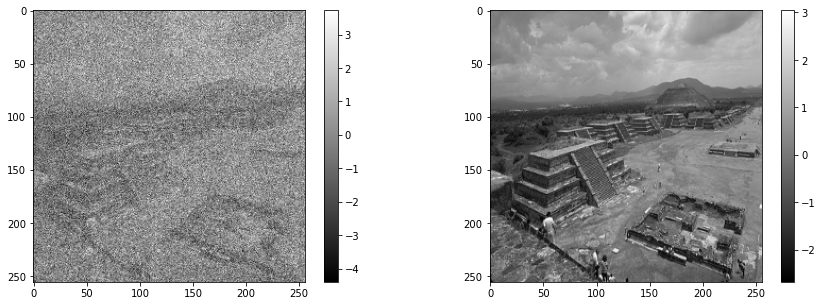

In [24]:
im = np.random.choice(images)
var = np.random.randint(1,100)
ys,xs = open_frame(im,var)

xs = xs/np.std(xs)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(xs,cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.imshow(ys,cmap='gray')
plt.colorbar()
plt.show()

In [38]:
import open_frame as OF

def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=True):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 

    ch, cw = yx[0].shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.rand()*360*float(do_rotate),
                            1+float(do_scale)*(np.random.uniform(-0.2,0.2)))
    for i in range(len(yx)):
        yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return yx
    
#N_REPEAT_FRAME = N_REPEAT_FRAME

def sample_images(frame_nums):
    while True:
        """
        try:
            var = np.random.uniform(var_d,var_u)
            img = open_frame(np.random.choice(frame_nums),var,CROP)
        except Exception as e:
            print(f'Exception {e} on file')
            #continue
            break
        """
        chosen_image = np.random.choice(frame_nums)
            
        for n in range(N_REPEAT_FRAME):
            
            var = np.random.randint(var_d,var_u)
            img = open_frame(chosen_image,var,CROP)
            a =  augment(np.copy(img),crop = CROP)
            yield a,var
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx,var = next(sampler)
            
            x,y = yx[1],yx[0]
            x = np.expand_dims(x,axis=-1)
            y = np.expand_dims(y,axis=-1)
            
            if k_var:
                var = np.array([var])
                
                yield {'image':x,'var':var},y
            
            else:
                yield x,y
                    
    return get_data

    
    
def get_generators(typ,var1_d,var1_u,BATCH_SIZE = 50, CROP1 = 256,
                  known_variance=True,N_REPEAT_FRAME1=1):

    test = glob('../../images/test/*.jpg')
    train = glob('../../images/train/*.jpg')


    global open_frame
    open_frame = getattr(OF,typ)
    
    global var_d
    var_d = var1_d

    global var_u
    var_u = var1_u

    global CROP
    CROP = CROP1
    
    global k_var
    k_var = known_variance
    
    global N_REPEAT_FRAME
    N_REPEAT_FRAME = N_REPEAT_FRAME1
    
    
    if k_var:
        
        dg_train = tf.data.Dataset.from_generator(
            get_data_generator(sample_images(train)),
            output_types=({'image':tf.float32,'var':tf.int32}, tf.float32),
            output_shapes=({'image':(CROP, CROP, 1),'var':(1,)},(CROP, CROP, 1)) )

        dg_val = tf.data.Dataset.from_generator(
            get_data_generator(sample_images(test)),
            output_types=({'image':tf.float32,'var':tf.int32}, tf.float32),
            output_shapes=({'image':(CROP, CROP, 1),'var':(1,)},(CROP, CROP, 1)) )

        gen_batch_train = dg_train.batch(BATCH_SIZE)
        gen_batch_val = dg_val.batch(BATCH_SIZE)

        
    else:

        dg_train = tf.data.Dataset.from_generator(
            get_data_generator(sample_images(train)),
            output_types=(tf.float32, tf.float32),
            output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

        dg_val = tf.data.Dataset.from_generator(
            get_data_generator(sample_images(test)),
            output_types=(tf.float32, tf.float32),
            output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

        gen_batch_train = dg_train.batch(BATCH_SIZE)
        gen_batch_val = dg_val.batch(BATCH_SIZE)

    return (gen_batch_train,gen_batch_val)

In [39]:
gen_batch_train,gen_batch_val = get_generators(typ,0,100,BATCH_SIZE = 50)

In [40]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

In [57]:
layer = tf.keras.layers.Embedding(1,1024)
layer(xs['var'])[0]


<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [58]:
layer.weights

[<tf.Variable 'embedding_5/embeddings:0' shape=(1, 1024) dtype=float32, numpy=
 array([[-8.7327845e-03, -1.7620623e-05, -4.9243666e-02, ...,
         -4.6943810e-02, -4.0486678e-03,  2.9609930e-02]], dtype=float32)>]